In [11]:
import os
import sys

from datetime import datetime

import numpy as np
import polars as pl

from scipy.optimize import minimize

# Add project root to sys.path
sys.path.append(os.path.abspath(".."))

from src.utils.data_loader import load_retail_data, load_tgp_data

start_date = datetime(2009, 4, 1)
end_date = datetime(2012, 5, 31)

In [12]:
os.getcwd()

'c:\\Users\\mmpei\\OneDrive\\Uni\\BSE\\Trimester 3\\thesis\\algo_price\\algorithmic_pricing_llms\\notebooks'

In [13]:
df_tgp = load_tgp_data(
    file_path="../data/113176-V1/data/TGP/tgpmin.csv",
    start_date=start_date,
    end_date=end_date,
).with_columns(pl.col("tgpmin").truediv(100).round(4))
df_ret = (
    load_retail_data(
        "../data/113176-V1/data/Prices", start_date=start_date, end_date=end_date
    )
    .rename(
        {"PUBLISH_DATE": "date", "BRAND_DESCRIPTION": "firm", "PRODUCT_PRICE": "price"}
    )
    .with_columns(pl.col("price").truediv(100).round(4))
    # .select(["date", "firm", "price"])
    # .filter(
    #    pl.col("firm").is_in(["BP", "Caltex", "Coles Express", "Caltex Woolworths"])
    # )
)

In [14]:
df_ret.describe()

statistic,date,TRADING_NAME,firm,PRODUCT_DESCRIPTION,price,ADDRESS,LOCATION,POSTCODE,,AREA_DESCRIPTION,REGION_DESCRIPTION
str,str,str,str,str,f64,str,str,f64,str,str,str
"""count""","""339740""","""339740""","""339740""","""339740""",339740.0,"""339740""","""339740""",339740.0,"""0""","""8970""","""8970"""
"""null_count""","""0""","""0""","""0""","""0""",0.0,"""0""","""0""",0.0,"""339740""","""330770""","""330770"""
"""mean""","""2010-11-02 05:43:51.070000""",null,null,null,1.314324,null,null,6085.676176,null,null,null
"""std""",null,null,null,null,0.121314,null,null,54.265556,null,null,null
"""min""","""2009-04-01""","""Ampol Doubleview""","""Ampol""","""ULP""",1.048,"""1 Broadway (Cnr Stirling Hwy)""","""ALEXANDER HEIGHTS""",6000.0,null,"""East/Hills""","""Metro"""
"""25%""","""2010-01-18""",null,null,null,1.219,null,null,6030.0,null,null,null
"""50%""","""2010-11-03""",null,null,null,1.299,null,null,6076.0,null,null,null
"""75%""","""2011-08-18""",null,null,null,1.417,null,null,6147.0,null,null,null
"""max""","""2012-05-31""","""Yanchep Service Station""","""Wesco""","""ULP""",1.88,"""Whitfords City Shopping Centre…","""YOKINE""",6180.0,null,"""South of River""","""Peel"""


In [15]:
df_tgp.describe()

statistic,date,tgpmin
str,str,f64
"""count""","""1157""",1157.0
"""null_count""","""0""",0.0
"""mean""","""2010-10-31 00:00:00""",1.231995
"""std""",null,0.095277
"""min""","""2009-04-01""",1.058
"""25%""","""2010-01-15""",1.154
"""50%""","""2010-10-31""",1.202
"""75%""","""2011-08-16""",1.321
"""max""","""2012-05-31""",1.441


## Calibrating parameters

In [16]:
import polars as pl
import numpy as np
from scipy.optimize import minimize
from typing import Dict, Tuple

In [17]:
major_firms = ["BP", "Caltex", "Coles Express", "Caltex Woolworths"]

In [18]:
def calibrate_demand_parameters(
    df_ret: pl.DataFrame,
    df_tgp: pl.DataFrame,
    major_firms: list = ["BP", "Caltex", "Coles Express", "Caltex Woolworths"],
    alpha: float = 1,  # Price scaling parameter
    beta: float = 1.0,  # Quantity scaling parameter
) -> Dict[str, float]:
    """
    Calibrate ai (brand preferences) and μ (substitutability) parameters
    using Perth market data to match observed market shares and markups.
    """

    # Step 1: Calculate market shares by firm (using station-day observations as proxy)
    market_shares = (
        df_ret.filter(pl.col("firm").is_in(major_firms))
        .group_by("firm")
        .agg(pl.len().alias("station_days"))
        .with_columns(
            (pl.col("station_days") / pl.col("station_days").sum()).alias(
                "market_share"
            )
        )
        .select(["firm", "market_share"])
        .to_dict(as_series=False)
    )

    share_dict = dict(zip(market_shares["firm"], market_shares["market_share"]))
    # {
    #     "BP": 0.22,
    #     "Caltex": 0.16,
    #     "Coles Express": 0.16,
    #     "Caltex Woolworths": 0.14,
    # }
    print("Observed market shares:", share_dict)

    # Step 2: Calculate average prices and margins by firm
    firm_stats = (
        df_ret.filter(pl.col("firm").is_in(major_firms))
        .join(df_tgp, on="date", how="inner")
        .group_by("firm")
        .agg(
            [
                pl.col("price").mean().alias("avg_price"),
                (pl.col("price") - pl.col("tgpmin")).mean().alias("avg_margin"),
                pl.len().alias("n_obs"),
            ]
        )
    )

    print("Firm statistics:")
    print(firm_stats)

    # Convert to dictionaries for optimization
    avg_prices = dict(zip(firm_stats["firm"], firm_stats["avg_price"]))
    avg_margins = dict(zip(firm_stats["firm"], firm_stats["avg_margin"]))

    # Step 3: Set up optimization
    baseline_firm = "Caltex Woolworths"  # Set as baseline
    baseline_a = 2

    def calculate_logit_shares(
        prices: Dict[str, float],
        preferences: Dict[str, float],
        mu: float,
        alpha: float,
        beta: float,
        a0: float = 0,
    ) -> Dict[str, float]:
        """Calculate market shares using logit demand formula"""

        # Calculate utilities
        utilities = {}
        for firm in major_firms:
            utilities[firm] = (preferences[firm] - prices[firm] / alpha) / mu

        # Calculate denominator (including outside option)
        exp_utilities = {firm: np.exp(u) for firm, u in utilities.items()}
        denominator = sum(exp_utilities.values()) + np.exp(a0 / mu)

        # Calculate market shares
        shares = {}
        for firm in major_firms:
            shares[firm] = beta * exp_utilities[firm] / denominator

        return shares

    def calculate_optimal_markups(
        shares: Dict[str, float], mu: float
    ) -> Dict[str, float]:
        """Calculate optimal markups using first-order conditions"""
        markups = {}
        for firm in major_firms:
            # Lerner index = μ / (1 - s_i) where s_i is market share
            if shares[firm] < 0.99:  # Avoid division by zero
                markups[firm] = mu / (1 - shares[firm])
            else:
                markups[firm] = mu / 0.01  # Cap at very high markup
        return markups

    def objective(params: np.ndarray) -> float:
        """Objective function: minimize deviations from observed shares and markups"""

        # Unpack parameters
        mu = params[0]

        # Set up preferences dictionary
        preferences = {baseline_firm: baseline_a}
        param_idx = 1
        for firm in major_firms:
            if firm != baseline_firm:
                preferences[firm] = params[param_idx]
                param_idx += 1

        try:
            # Calculate predicted market shares
            pred_shares = calculate_logit_shares(
                avg_prices, preferences, mu, alpha, beta
            )

            # Calculate predicted markups (in same units as observed margins)
            pred_markups_lerner = calculate_optimal_markups(pred_shares, mu)
            pred_markups = {
                firm: markup * avg_prices[firm]
                for firm, markup in pred_markups_lerner.items()
            }

            # Calculate losses
            share_loss = sum(
                (pred_shares[firm] - share_dict[firm]) ** 2 for firm in major_firms
            )
            markup_loss = sum(
                (pred_markups[firm] - avg_margins[firm]) ** 2 for firm in major_firms
            )

            # Weight the losses (markup matching is typically more important)
            total_loss = share_loss + 0.1 * markup_loss

            return total_loss

        except (ValueError, ZeroDivisionError, OverflowError):
            return 1e6  # Return large penalty for invalid parameters

    # Step 4: Optimize parameters
    n_other_firms = len(major_firms) - 1  # Exclude baseline firm

    # Initial guess: μ=0.25, other firms slightly different from baseline
    initial_guess = [0.25] + [baseline_a + 0.1 * i for i in range(n_other_firms)]

    # Bounds: μ ∈ [0.1, 0.5], ai ∈ [1.5, 2.5]
    bounds = [(0.01, 1)] + [(0, 10)] * n_other_firms

    print("Starting optimization...")
    result = minimize(objective, initial_guess, method="L-BFGS-B", bounds=bounds)

    if not result.success:
        print(f"Optimization warning: {result.message}")

    # Step 5: Extract and return results
    mu_calibrated = result.x[0]

    preferences_calibrated = {baseline_firm: baseline_a}
    param_idx = 1
    for firm in major_firms:
        if firm != baseline_firm:
            preferences_calibrated[firm] = result.x[param_idx]
            param_idx += 1

    # Validate results
    final_shares = calculate_logit_shares(
        avg_prices, preferences_calibrated, mu_calibrated, alpha, beta
    )
    final_markups_lerner = calculate_optimal_markups(final_shares, mu_calibrated)
    final_markups = {
        firm: markup * avg_prices[firm] for firm, markup in final_markups_lerner.items()
    }

    print("\n=== Calibration Results ===")
    print(f"μ (substitutability): {mu_calibrated:.3f}")
    print("Brand preferences (ai):")
    for firm in major_firms:
        print(f"  {firm}: {preferences_calibrated[firm]:.3f}")

    print("\nValidation:")
    df_val = pl.DataFrame(
        {
            "Firm": major_firms,
            "Observed Share": [share_dict[firm] for firm in major_firms],
            "Predicted Share": [final_shares[firm] for firm in major_firms],
            "Observed Margin": [avg_margins[firm] for firm in major_firms],
            "Predicted Margin": [final_markups[firm] for firm in major_firms],
        }
    )

    print(df_val)

    # Return all calibrated parameters
    calibrated_params = {
        "mu": mu_calibrated,
        "alpha": alpha,
        "beta": beta,
        "a0": 0.0,  # Outside option
        **{f"a_{firm}": preferences_calibrated[firm] for firm in major_firms},
    }

    return calibrated_params

In [ ]:
def create_demand_function(params: Dict[str, float], major_firms: list):
    """
    Create a demand function using calibrated parameters
    """

    def demand_function(
        prices: Dict[str, float], marginal_costs: Dict[str, float]
    ) -> Dict[str, Dict[str, float]]:
        """
        Calculate quantities and profits for given prices and costs

        Returns:
            Dict with 'quantities' and 'profits' for each firm
        """
        mu = params["mu"]
        alpha = params["alpha"]
        beta = params["beta"]
        a0 = params["a0"]

        # Calculate utilities
        utilities = {}
        for firm in major_firms:
            a_firm = params[f"a_{firm}"]
            utilities[firm] = (a_firm - prices[firm] / alpha) / mu

        # Calculate market shares
        exp_utilities = {firm: np.exp(u) for firm, u in utilities.items()}
        denominator = sum(exp_utilities.values()) + np.exp(a0 / mu)

        quantities = {}
        profits = {}

        for firm in major_firms:
            quantities[firm] = beta * exp_utilities[firm] / denominator
            profits[firm] = (
                (prices[firm] - alpha * marginal_costs[firm]) * quantities[firm]
            )

        return {"quantities": quantities, "profits": profits}

    return demand_function


In [20]:
# Assuming df_ret and df_tgp are already loaded
params = calibrate_demand_parameters(df_ret, df_tgp)

Observed market shares: {'Coles Express': 0.24345689748885752, 'Caltex Woolworths': 0.2108533536253941, 'Caltex': 0.22545059245570173, 'BP': 0.32023915643004675}
Firm statistics:
shape: (4, 4)
┌───────────────────┬───────────┬────────────┬───────┐
│ firm              ┆ avg_price ┆ avg_margin ┆ n_obs │
│ ---               ┆ ---       ┆ ---        ┆ ---   │
│ str               ┆ f64       ┆ f64        ┆ u32   │
╞═══════════════════╪═══════════╪════════════╪═══════╡
│ BP                ┆ 1.326397  ┆ 0.094374   ┆ 73647 │
│ Coles Express     ┆ 1.307751  ┆ 0.075492   ┆ 55989 │
│ Caltex Woolworths ┆ 1.306968  ┆ 0.073269   ┆ 48491 │
│ Caltex            ┆ 1.314256  ┆ 0.07851    ┆ 51848 │
└───────────────────┴───────────┴────────────┴───────┘
Starting optimization...

=== Calibration Results ===
μ (substitutability): 0.046
Brand preferences (ai):
  BP: 2.039
  Caltex: 2.010
  Coles Express: 2.007
  Caltex Woolworths: 2.000

Validation:
shape: (4, 5)
┌───────────────────┬────────────────┬────────

In [21]:
# Create demand function for LLM agents
major_firms = ["BP", "Caltex", "Coles Express", "Caltex Woolworths"]
demand_func = create_demand_function(params, major_firms)

# Test the demand function
test_prices = {
    "BP": 1.23,
    "Caltex": 1.16,
    "Coles Express": 1.16,
    "Caltex Woolworths": 1.11,
}
test_costs = {
    "BP": 1.107,
    "Caltex": 1.107,
    "Coles Express": 1.107,
    "Caltex Woolworths": 1.107,
}  # Will be replaced with TGP

results = demand_func(test_prices, test_costs)
print("\nTest demand function:")
print("Quantities:", results["quantities"])
print("Profits:", results["profits"])


Test demand function:
Quantities: {'BP': np.float64(0.08530750306701936), 'Caltex': np.float64(0.2121739494093012), 'Coles Express': np.float64(0.1987657898199881), 'Caltex Woolworths': np.float64(0.5037527558422817)}
Profits: {'BP': np.float64(0.020985645754486762), 'Caltex': np.float64(0.0224904386373859), 'Coles Express': np.float64(0.021069173720918714), 'Caltex Woolworths': np.float64(0.003022516535053805)}


## Applying the model to the data

In [22]:
# Polars demand function
def apply_demand_function_vectorized(df: pl.DataFrame, demand_func) -> pl.DataFrame:
    """
    More efficient vectorized approach using pivot and join operations.
    """

    # Get unique dates
    dates = df["date"].unique().sort()

    results_list = []

    for date in dates:
        # Get data for this date
        date_data = df.filter(pl.col("date") == date)

        # Convert to dictionaries
        prices = dict(zip(date_data["firm"], date_data["price"]))
        marginal_costs = dict(zip(date_data["firm"], date_data["tgpmin"]))

        try:
            # Apply demand function
            results = demand_func(prices, marginal_costs)

            # Create result dataframe for this date
            date_results = pl.DataFrame(
                {
                    "date": [date] * len(results["quantities"]),
                    "firm": list(results["quantities"].keys()),
                    "quantity": list(results["quantities"].values()),
                    "profit": list(results["profits"].values()),
                }
            )

            results_list.append(date_results)

        except Exception as e:
            # Handle errors by creating zero results
            date_results = pl.DataFrame(
                {
                    "date": [date] * len(date_data),
                    "firm": date_data["firm"].to_list(),
                    "quantity": [0.0] * len(date_data),
                    "profit": [0.0] * len(date_data),
                }
            )
            results_list.append(date_results)

    # Combine all results
    all_results = pl.concat(results_list).with_columns(pl.col("profit").round(4))

    # Join back with original dataframe
    final_df = df.join(all_results, on=["date", "firm"], how="left")

    return final_df

In [23]:
df = (
    df_ret.select(["date", "firm", "price"])
    .filter(
        pl.col("firm").is_in(["BP", "Caltex", "Coles Express", "Caltex Woolworths"])
        & pl.col("date").is_between(datetime(2009, 4, 1), datetime(2012, 5, 1))
    )
    .group_by(["date", "firm"], maintain_order=True)
    .agg(pl.col("price").mean())
    .join(df_tgp, how="inner", on="date")
    .with_columns(
        pl.col("price").sub(pl.col("tgpmin")).round(4).alias("real_profit"),
        pl.int_range(pl.len()).over(["firm"]).alias("counter"),
    )
)

df = apply_demand_function_vectorized(
    df, demand_func=create_demand_function(params, major_firms=major_firms)
)

In [24]:
df[["profit", "real_profit"]].corr()

profit,real_profit
f64,f64
1.0,0.745897
0.745897,1.0


In [30]:
def create_scaled_demand_function(
    params: Dict[str, float], major_firms: list, market_size: float = 1.0
):
    """
    Create a properly scaled demand function
    """

    def demand_function(
        prices: Dict[str, float], marginal_costs: Dict[str, float]
    ) -> Dict[str, Dict[str, float]]:
        mu = params["mu"]
        alpha = params["alpha"]
        beta = params["beta"]
        a0 = params["a0"]

        # Calculate utilities (consistent alpha usage)
        utilities = {}
        for firm in major_firms:
            a_firm = params[f"a_{firm}"]
            utilities[firm] = (a_firm - alpha * prices[firm]) / mu

        # Calculate market shares
        exp_utilities = {firm: np.exp(u) for firm, u in utilities.items()}
        denominator = sum(exp_utilities.values()) + np.exp(a0 / mu)

        quantities = {}
        profits = {}

        for firm in major_firms:
            # Scale quantities by market size
            quantities[firm] = market_size * beta * exp_utilities[firm] / denominator

            # Remove arbitrary factor of 2, use consistent pricing
            profits[firm] = (prices[firm] - marginal_costs[firm]) * quantities[firm]

        return {"quantities": quantities, "profits": profits}

    return demand_function


def calibrate_with_profit_scaling(
    df_ret: pl.DataFrame, df_tgp: pl.DataFrame, major_firms: list
):
    """
    Calibrate parameters including a profit scaling factor
    """

    # First calibrate base parameters
    base_params = calibrate_demand_parameters(df_ret, df_tgp, major_firms)

    # Calculate observed total profits for scaling
    observed_data = (
        df_ret.filter(pl.col("firm").is_in(major_firms))
        .join(df_tgp, on="date", how="inner")
        .with_columns((pl.col("price") - pl.col("tgpmin")).alias("observed_profit"))
    )

    total_observed_profit = observed_data["observed_profit"].sum()

    # Test different market sizes to match profit scale
    def find_optimal_market_size(market_size: float) -> float:
        demand_func = create_scaled_demand_function(
            base_params, major_firms, market_size
        )

        # Apply to subset of data
        test_data = observed_data.sample(n=100)  # Sample for efficiency

        total_predicted_profit = 0
        for row in test_data.iter_rows(named=True):
            prices = {row["firm"]: row["price"]}
            costs = {row["firm"]: row["tgpmin"]}

            # Get other firms' average prices for this date (simplified)
            avg_prices = (
                observed_data.filter(pl.col("date") == row["date"])
                .select(pl.col("price").mean())
                .item()
            )

            for firm in major_firms:
                if firm not in prices:
                    prices[firm] = avg_prices
                    costs[firm] = row["tgpmin"]

            results = demand_func(prices, costs)
            total_predicted_profit += results["profits"][row["firm"]]

        return abs(total_predicted_profit - test_data["observed_profit"].sum())

    # Optimize market size
    from scipy.optimize import minimize_scalar

    result = minimize_scalar(
        find_optimal_market_size, bounds=(0.1, 10), method="bounded"
    )
    optimal_market_size = result.x

    return base_params, optimal_market_size

## Plotting

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

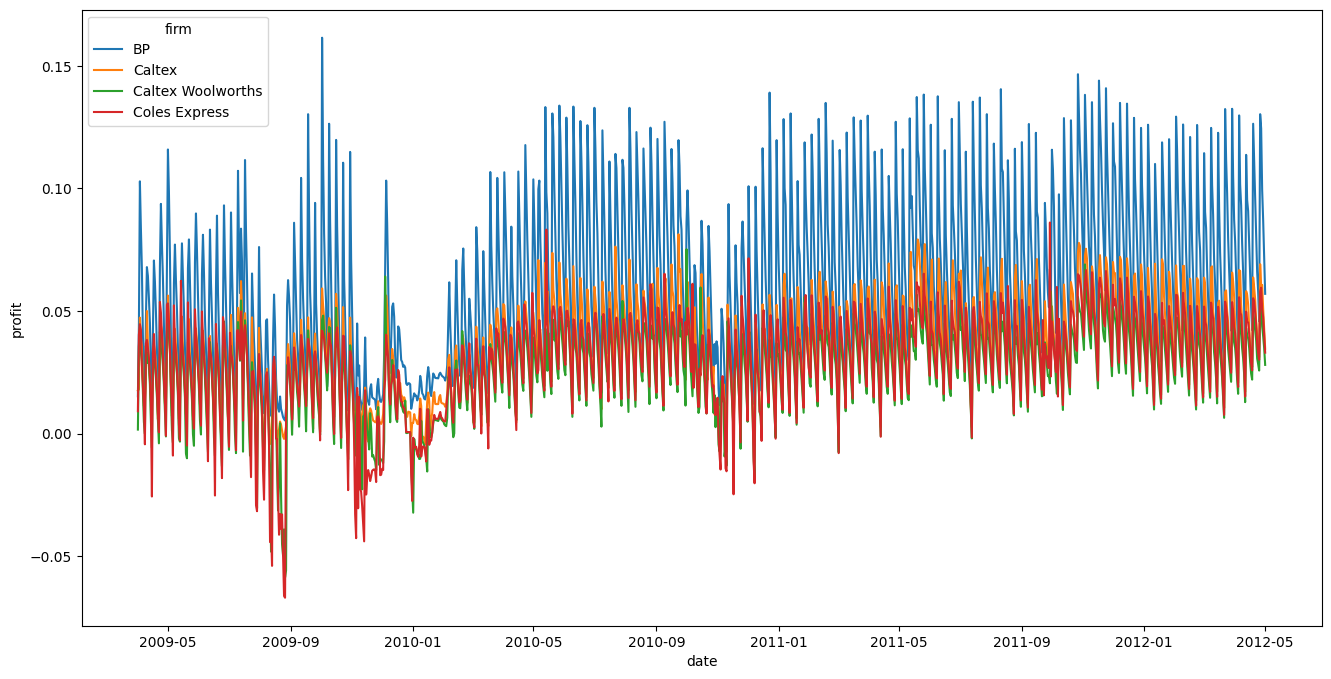

In [26]:
plt.figure(figsize=(16, 8))
sns.lineplot(
    data=df,
    x="date",
    y="profit",
    hue="firm",
)
plt.show()

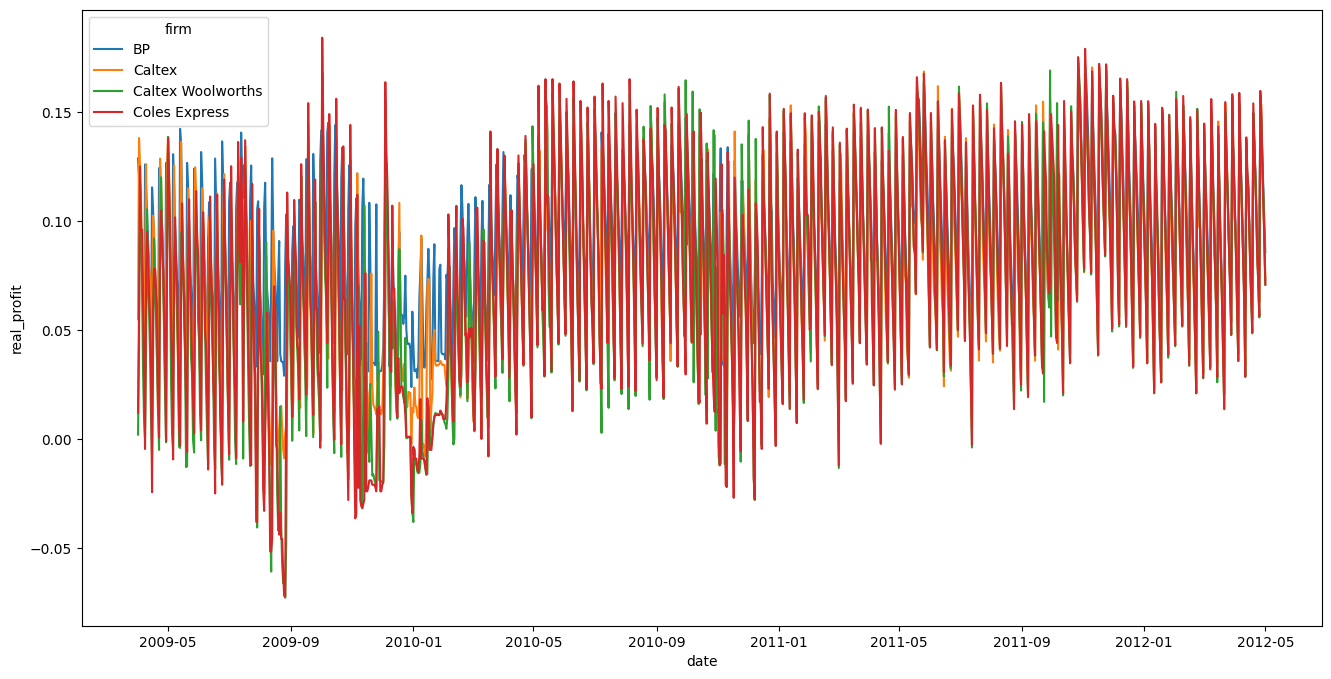

In [27]:
plt.figure(figsize=(16, 8))
sns.lineplot(
    data=df,
    x="date",
    y="real_profit",
    hue="firm",
)
plt.show()

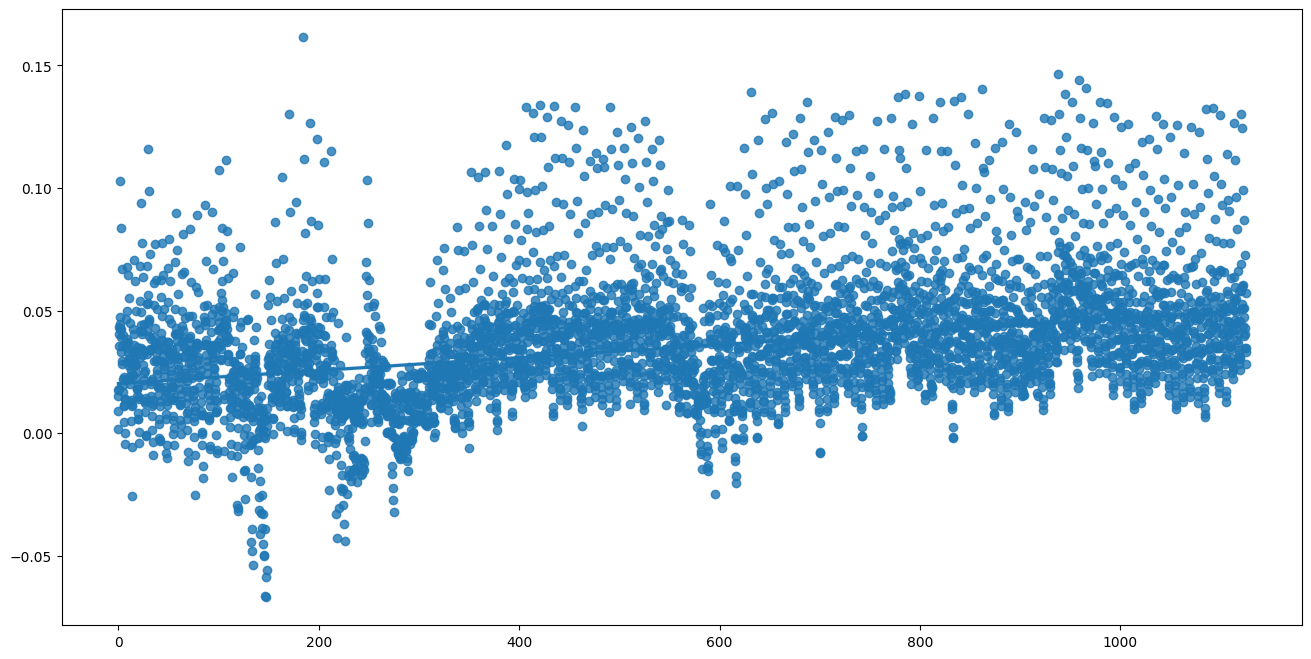

In [28]:
plt.figure(figsize=(16, 8))
sns.regplot(
    data=df,
    x="counter",
    y="profit",
    robust=True,
)
plt.show()

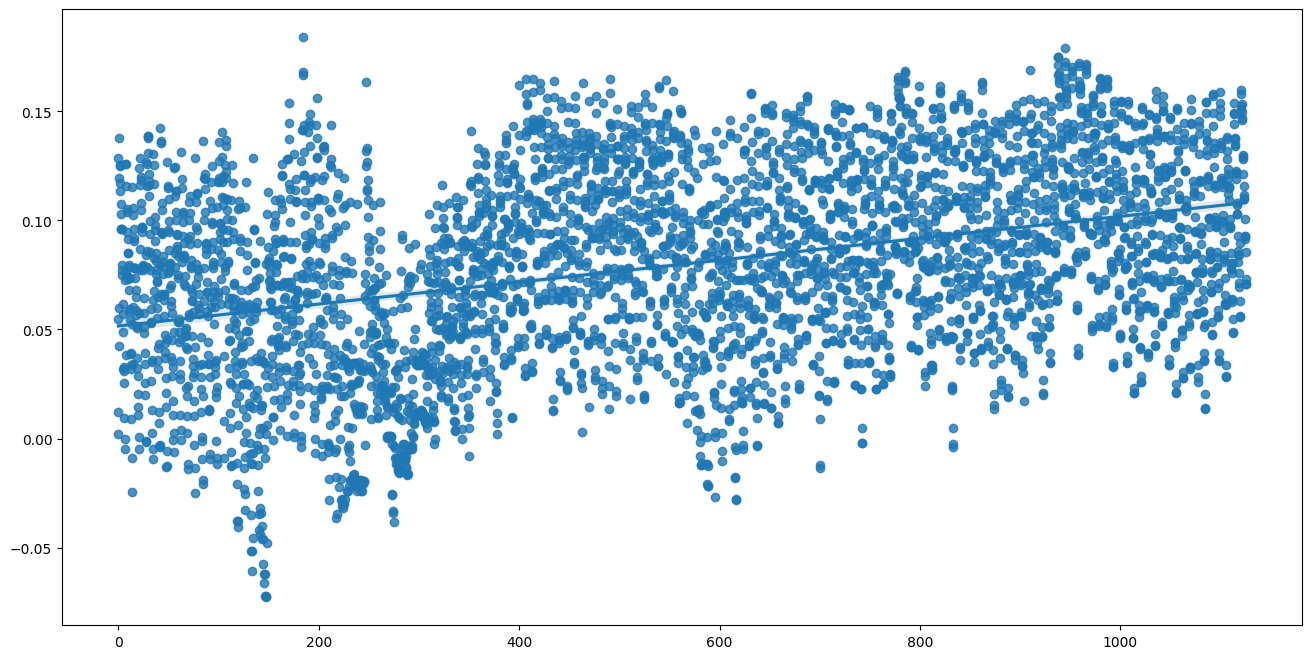

In [29]:
plt.figure(figsize=(16, 8))
sns.regplot(
    data=df,
    x="counter",
    y="real_profit",
    robust=True,
)
plt.show()